![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
plt.style.use('fivethirtyeight')

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [3]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [4]:
epidemic_duration_in_days = 365

Tamanho da população.

In [5]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [6]:
initially_infected = 52

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [7]:
target_location = 'Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [8]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [9]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [10]:
results_suffix = ''

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [11]:
# custom papermill parameters

In [12]:
# Parameters
target_location = "Italy"
infer_parameters_from_data = True
results_suffix = ".italy"


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [13]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    df_simulated_data = df_simulated_data[['S', 'E', 'I', 'R', 'E+I']]
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data)
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']])
    ax.set_title('Apenas Expostos e Infectados')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
        if file_name is not None:
            ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [14]:
df_epidemy_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv('../data/ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')
df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population
0,2019-12-31,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,Afghanistan,Asia,2020.0,38928341.0


Selecionemos apenas dados sobre o país de interesse.

In [15]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-03-31,4050,810,101739,11591,Italy,Europe,2020.0,60461828.0,NaN,1017390
2020-04-01,4053,839,105792,12430,Italy,Europe,2020.0,60461828.0,NaN,1057920
2020-04-02,4782,727,110574,13157,Italy,Europe,2020.0,60461828.0,NaN,1105740
2020-04-03,4668,760,115242,13917,Italy,Europe,2020.0,60461828.0,NaN,1152420
2020-04-04,4585,764,119827,14681,Italy,Europe,2020.0,60461828.0,NaN,1198270


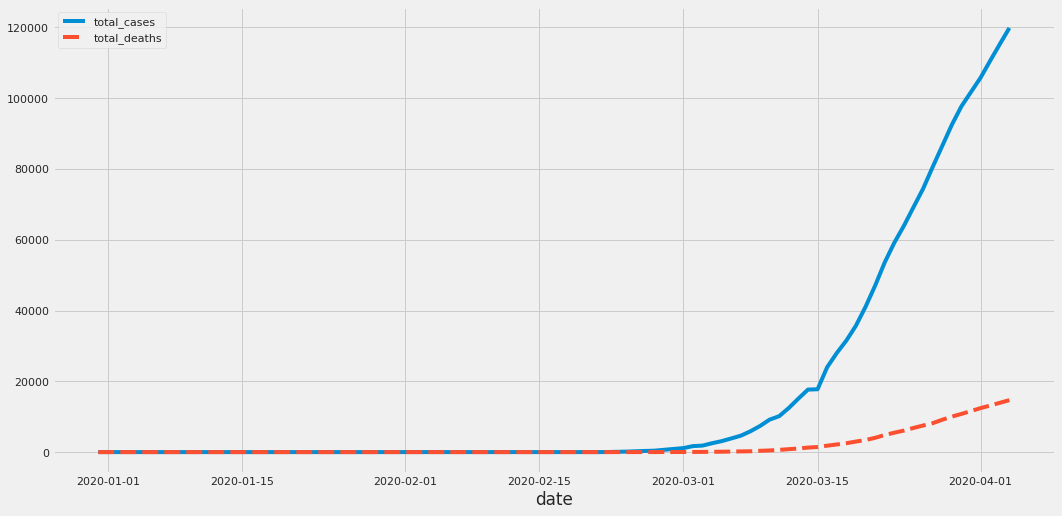

In [16]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 10 * df_data_target['total_cases']

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [17]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-02-23 00:00:00')

In [18]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-02-23 00:00:00, population_size=60461828.0, initially_infected=79


Filtremos os dados a partir da data de interesse.

In [19]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [20]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [21]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [22]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    for value, length in regimens:
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [23]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [24]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [25]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [26]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [27]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [28]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

### Simulação

A simulação então pode ser definida do seguinte modo.

In [29]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func):
    
    generated_data = [] # initial data
    
    E_delta = 0
    I_delta = 0 # changes start at 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [30]:
alpha = 1.0   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,E+I
2020-02-23,6.046175e+07,79.000000,0.000000,0.000000,0.000000,0.000000,79.000000
2020-02-24,6.046175e+07,0.000000,0.000000,79.000000,79.000000,0.000000,79.000000
2020-02-25,6.046169e+07,63.199917,63.199917,55.300000,0.000000,23.700000,118.499917
2020-02-26,6.046164e+07,44.239896,44.239896,101.909917,63.199917,40.290000,146.149813
2020-02-27,6.046156e+07,81.527683,81.527683,115.576838,44.239896,70.862975,197.104521


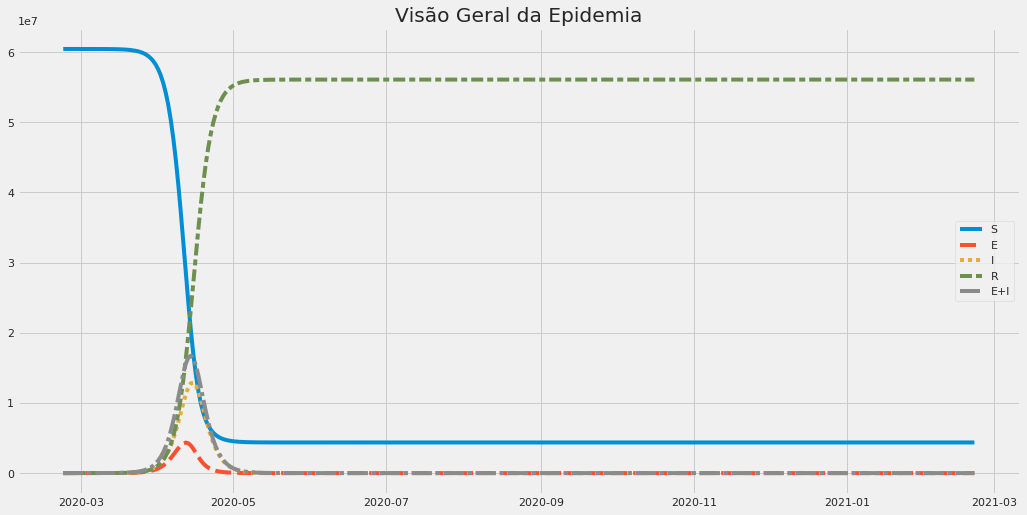

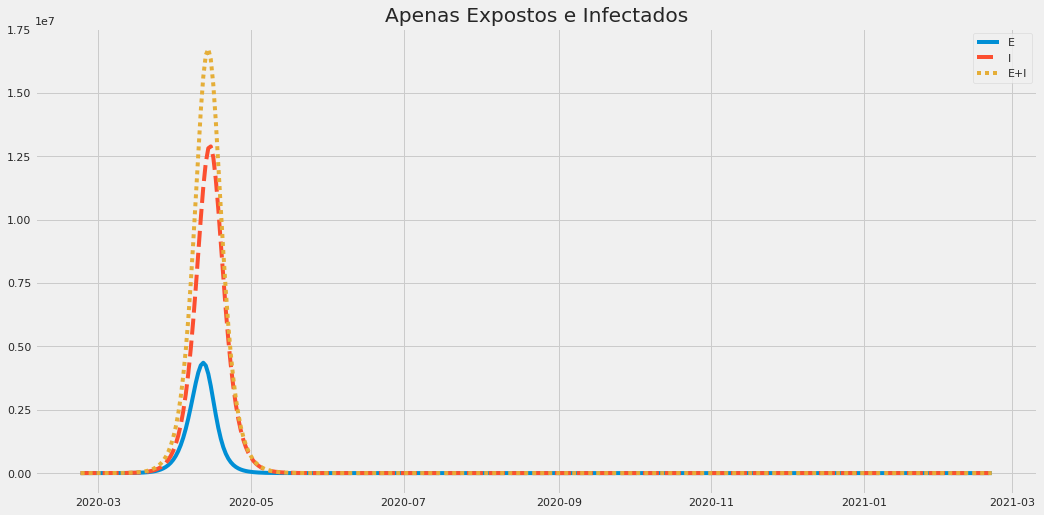

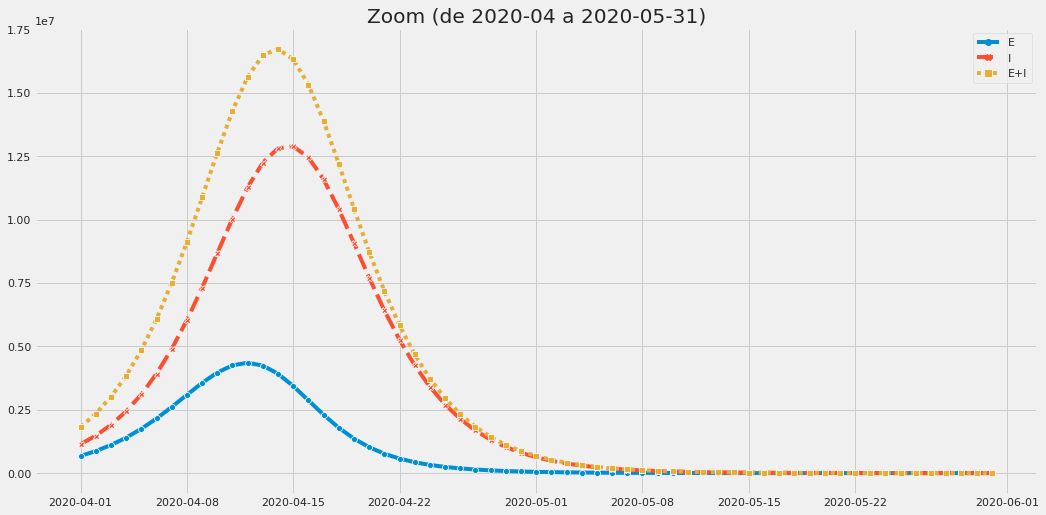

<Figure size 1152x576 with 0 Axes>

In [31]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

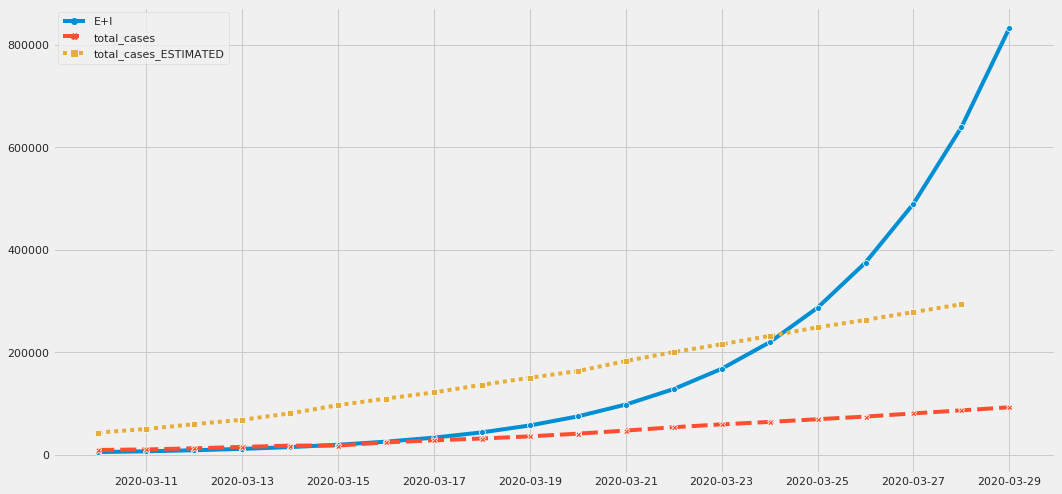

In [32]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [33]:
beta = dynamic_parameter([(0.3, 30), 
                          (0.1, 60), 
                          (0.05, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)


,S,E,E_delta,I,I_delta,R,E+I
2020-02-23,6.046175e+07,79.000000,0.000000,0.000000,0.000000,0.000000,79.000000
2020-02-24,6.046175e+07,0.000000,0.000000,79.000000,79.000000,0.000000,79.000000
2020-02-25,6.046173e+07,23.699969,23.699969,55.300000,0.000000,23.700000,78.999969
2020-02-26,6.046171e+07,16.589972,16.589972,62.409969,23.699969,40.290000,78.999941
2020-02-27,6.046169e+07,18.722954,18.722954,60.276950,16.589972,59.012991,78.999904


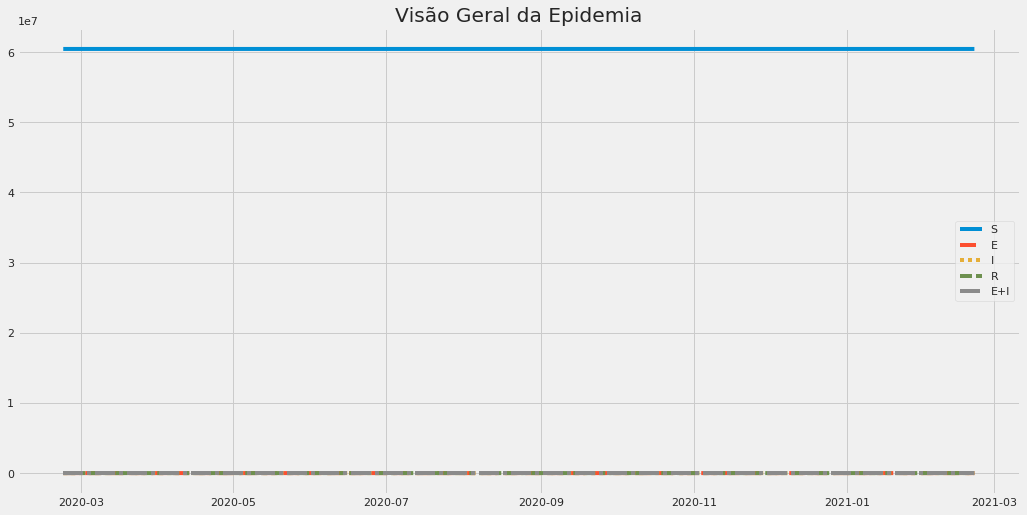

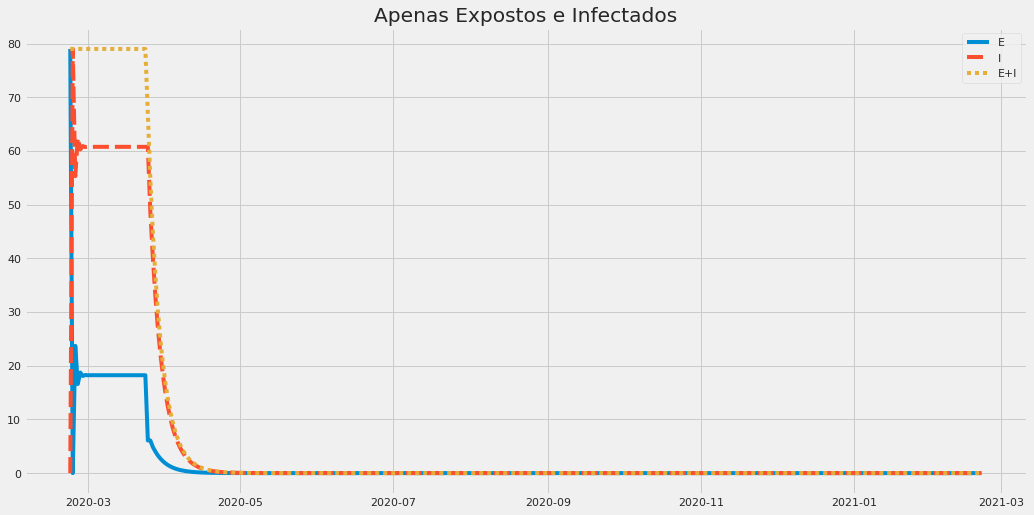

<Figure size 1152x576 with 0 Axes>

In [34]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [35]:
def objective_for_simulation(args):
    alpha, beta, gamma = args
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    df_diff_cases = df_data_target['total_cases_ESTIMATED'] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'])

    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [36]:
space = (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0))

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=300, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

  3%|▎         | 9/300 [00:00<00:03, 81.23trial/s, best loss: 49360.39535205511]

  6%|▌         | 17/300 [00:00<00:03, 80.58trial/s, best loss: 49360.39535205511]

  8%|▊         | 24/300 [00:00<00:03, 72.62trial/s, best loss: 49360.39535205511]

 10%|▉         | 29/300 [00:00<00:04, 63.19trial/s, best loss: 49360.39535205511]

 11%|█▏        | 34/300 [00:00<00:04, 57.93trial/s, best loss: 49360.39535205511]

 13%|█▎        | 39/300 [00:00<00:04, 54.54trial/s, best loss: 49360.39535205511]

 15%|█▍        | 44/300 [00:00<00:04, 52.18trial/s, best loss: 49360.39535205511]

 16%|█▋        | 49/300 [00:00<00:04, 50.59trial/s, best loss: 48350.65024002704]

 18%|█▊        | 54/300 [00:00<00:04, 49.70trial/s, best loss: 48350.65024002704]

 20%|█▉        | 59/300 [00:01<00:04, 48.84trial/s, best loss: 47902.62720540865]

 21%|██▏       | 64/300 [00:01<00:04, 48.29trial/s, best loss: 47902.62720540865]

 23%|██▎       | 69/300 [00:01<00:04, 47.56trial/s, best loss: 47902.62720540865]

 25%|██▍       | 74/300 [00:01<00:04, 46.07trial/s, best loss: 47902.62720540865]

 26%|██▋       | 79/300 [00:01<00:04, 46.22trial/s, best loss: 47902.62720540865]

 28%|██▊       | 84/300 [00:01<00:04, 46.32trial/s, best loss: 47902.62720540865]

 30%|██▉       | 89/300 [00:01<00:04, 46.13trial/s, best loss: 47902.62720540865]

 31%|███▏      | 94/300 [00:01<00:04, 46.06trial/s, best loss: 47902.62720540865]

 33%|███▎      | 99/300 [00:01<00:04, 45.97trial/s, best loss: 47902.62720540865]

 35%|███▍      | 104/300 [00:02<00:04, 45.58trial/s, best loss: 47902.62720540865]

 36%|███▋      | 109/300 [00:02<00:04, 45.25trial/s, best loss: 47902.62720540865]

 38%|███▊      | 114/300 [00:02<00:04, 44.93trial/s, best loss: 47902.62720540865]

 40%|███▉      | 119/300 [00:02<00:04, 44.47trial/s, best loss: 47902.62720540865]

 41%|████▏     | 124/300 [00:02<00:03, 44.00trial/s, best loss: 47902.62720540865]

 43%|████▎     | 129/300 [00:02<00:03, 44.38trial/s, best loss: 47902.62720540865]

 45%|████▍     | 134/300 [00:02<00:03, 44.65trial/s, best loss: 47902.62720540865]

 46%|████▋     | 139/300 [00:02<00:03, 44.70trial/s, best loss: 47902.62720540865]

 48%|████▊     | 144/300 [00:02<00:03, 44.50trial/s, best loss: 47720.1695429233] 

 50%|████▉     | 149/300 [00:03<00:03, 44.52trial/s, best loss: 47720.1695429233]

 51%|█████▏    | 154/300 [00:03<00:03, 44.31trial/s, best loss: 47720.1695429233]

 53%|█████▎    | 159/300 [00:03<00:03, 44.16trial/s, best loss: 47720.1695429233]

 55%|█████▍    | 164/300 [00:03<00:03, 43.23trial/s, best loss: 47720.1695429233]

 56%|█████▋    | 169/300 [00:03<00:03, 43.16trial/s, best loss: 47720.1695429233]

 58%|█████▊    | 174/300 [00:03<00:02, 43.17trial/s, best loss: 47720.1695429233]

 60%|█████▉    | 179/300 [00:03<00:02, 43.28trial/s, best loss: 47720.1695429233]

 61%|██████▏   | 184/300 [00:03<00:02, 43.45trial/s, best loss: 47720.1695429233]

 63%|██████▎   | 189/300 [00:03<00:02, 43.40trial/s, best loss: 47720.1695429233]

 65%|██████▍   | 194/300 [00:04<00:02, 43.51trial/s, best loss: 47720.1695429233]

 66%|██████▋   | 199/300 [00:04<00:02, 43.35trial/s, best loss: 47720.1695429233]

 68%|██████▊   | 204/300 [00:04<00:02, 41.86trial/s, best loss: 47720.1695429233]

 70%|██████▉   | 209/300 [00:04<00:02, 41.56trial/s, best loss: 47720.1695429233]

 71%|███████▏  | 214/300 [00:04<00:02, 42.13trial/s, best loss: 47720.1695429233]

 73%|███████▎  | 219/300 [00:04<00:01, 42.34trial/s, best loss: 47720.1695429233]

 75%|███████▍  | 224/300 [00:04<00:01, 42.39trial/s, best loss: 47720.1695429233]

 76%|███████▋  | 229/300 [00:04<00:01, 42.51trial/s, best loss: 47720.1695429233]

 78%|███████▊  | 234/300 [00:05<00:01, 42.23trial/s, best loss: 47720.1695429233]

 80%|███████▉  | 239/300 [00:05<00:01, 41.30trial/s, best loss: 47720.1695429233]

 81%|████████▏ | 244/300 [00:05<00:01, 40.78trial/s, best loss: 47720.1695429233]

 83%|████████▎ | 249/300 [00:05<00:01, 40.30trial/s, best loss: 47720.1695429233]

 85%|████████▍ | 254/300 [00:05<00:01, 40.67trial/s, best loss: 47720.1695429233]

 86%|████████▋ | 259/300 [00:05<00:01, 40.86trial/s, best loss: 47720.1695429233]

 88%|████████▊ | 264/300 [00:05<00:00, 41.23trial/s, best loss: 47720.1695429233]

 90%|████████▉ | 269/300 [00:05<00:00, 41.56trial/s, best loss: 47720.1695429233]

 91%|█████████▏| 274/300 [00:06<00:00, 42.05trial/s, best loss: 47612.49453685409]

 93%|█████████▎| 279/300 [00:06<00:00, 36.59trial/s, best loss: 47612.49453685409]

 95%|█████████▍| 284/300 [00:06<00:00, 37.94trial/s, best loss: 47612.49453685409]

 96%|█████████▋| 289/300 [00:06<00:00, 38.96trial/s, best loss: 47612.49453685409]

 98%|█████████▊| 294/300 [00:06<00:00, 39.63trial/s, best loss: 47612.49453685409]

100%|█████████▉| 299/300 [00:06<00:00, 40.18trial/s, best loss: 47612.49453685409]

100%|██████████| 300/300 [00:06<00:00, 44.65trial/s, best loss: 47612.49453685409]


Best parameters found: {'alpha': 0.479891142283555, 'beta': 0.8164728780191373, 'gamma': 0.20272191177519203}


In [37]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,E+I
2020-03-16,6.043608e+07,9907.089272,5942.413073,9462.716790,3658.105341,6373.326362,19369.806062
2020-03-17,6.042836e+07,12875.526937,7722.762052,12298.741139,4754.324388,8291.626400,25174.268076
2020-03-18,6.041833e+07,16732.706117,10036.030509,15984.368152,6178.851329,10784.850716,32717.074269
2020-03-19,6.040528e+07,21744.241759,13041.413094,20773.863934,8029.877452,14025.232387,42518.105692
2020-03-20,6.038834e+07,28254.807170,16945.434427,26997.415538,10434.869016,18236.549798,55252.222708


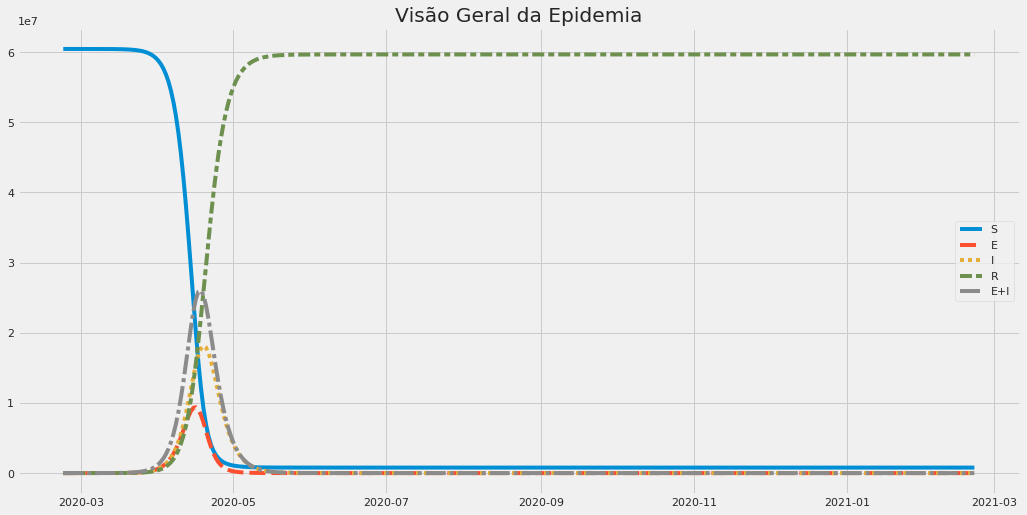

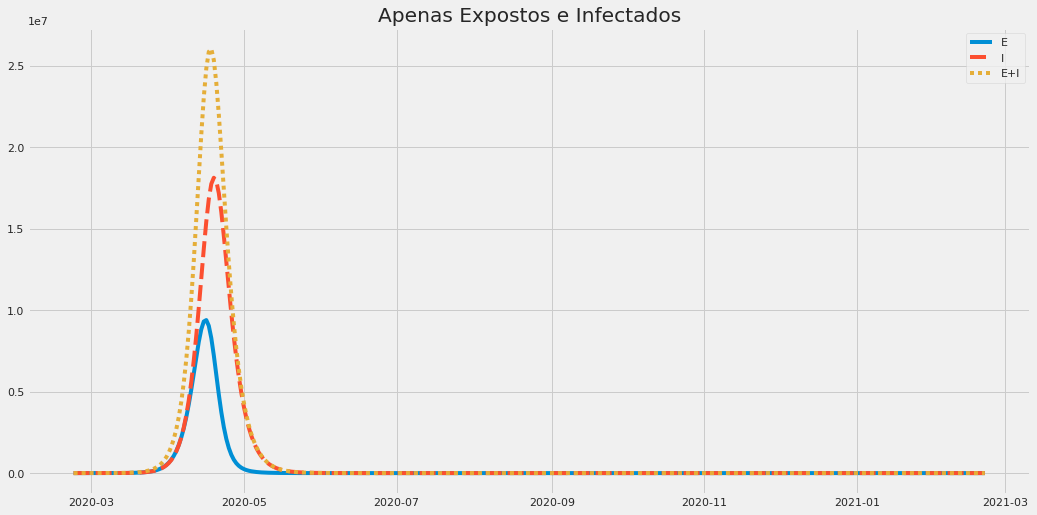

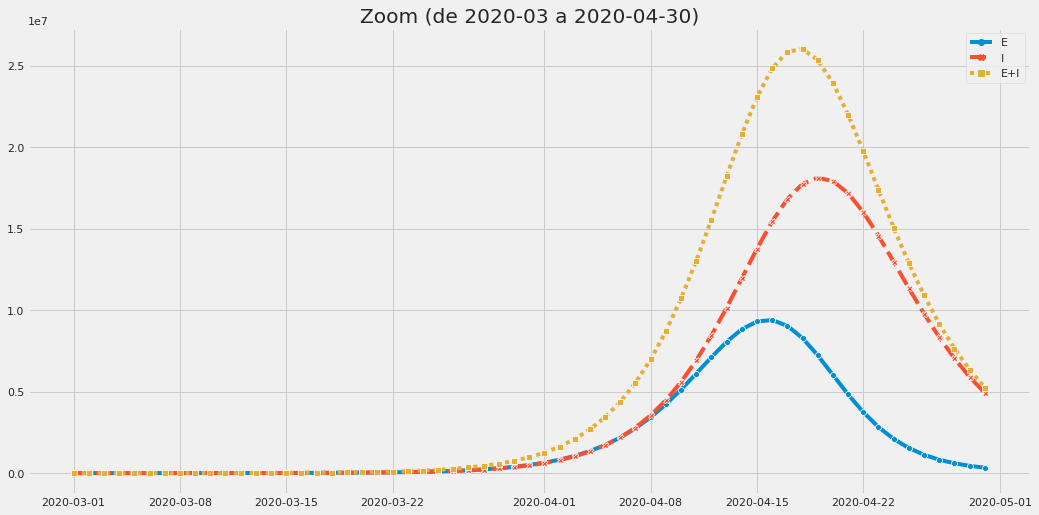

<Figure size 1152x576 with 0 Axes>

In [38]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-03', file_name='no-mitigation')
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [39]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,countriesAndTerritories,continent,population_year,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2
date,,,,,,,,,,
2020-03-31,4050,810,101739,11591,Italy,Europe,2020.0,60461828.0,NaN,1017390
2020-04-01,4053,839,105792,12430,Italy,Europe,2020.0,60461828.0,NaN,1057920
2020-04-02,4782,727,110574,13157,Italy,Europe,2020.0,60461828.0,NaN,1105740
2020-04-03,4668,760,115242,13917,Italy,Europe,2020.0,60461828.0,NaN,1152420
2020-04-04,4585,764,119827,14681,Italy,Europe,2020.0,60461828.0,NaN,1198270


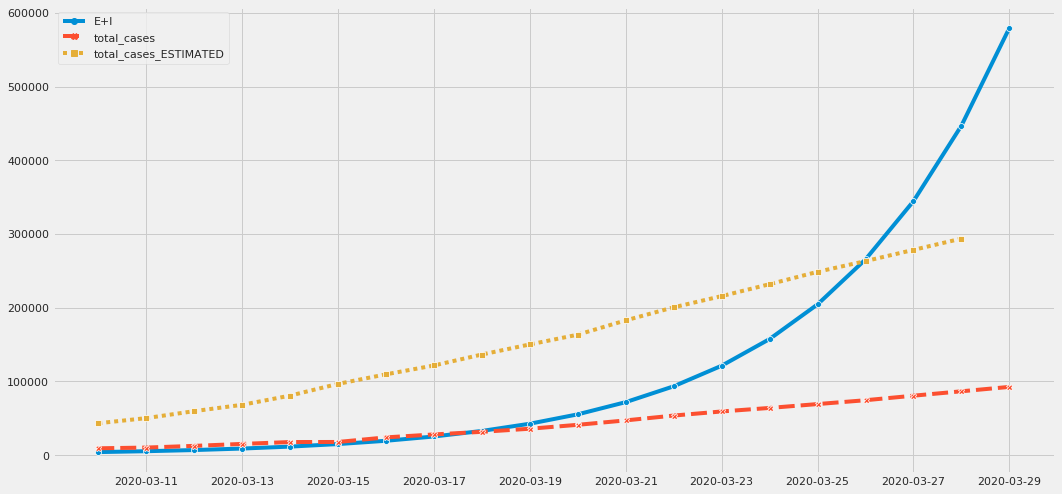

In [40]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Salvemos os resultados.

In [41]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo medidas de mitigação que reduzem o contágio após alguns dias iniciais com os parâmetros inferidos anteriormente.

In [42]:
#alpha = dynamic_parameter([(best['alpha'], 11), 
#                          (best['alpha']/1.8, 30), 
#                          (best['alpha']/2, epidemic_duration_in_days)],
#                         min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta'], 11), 
                          (best['beta']/1.7, 30), 
                          (best['beta']/1.1, epidemic_duration_in_days)],
                         min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

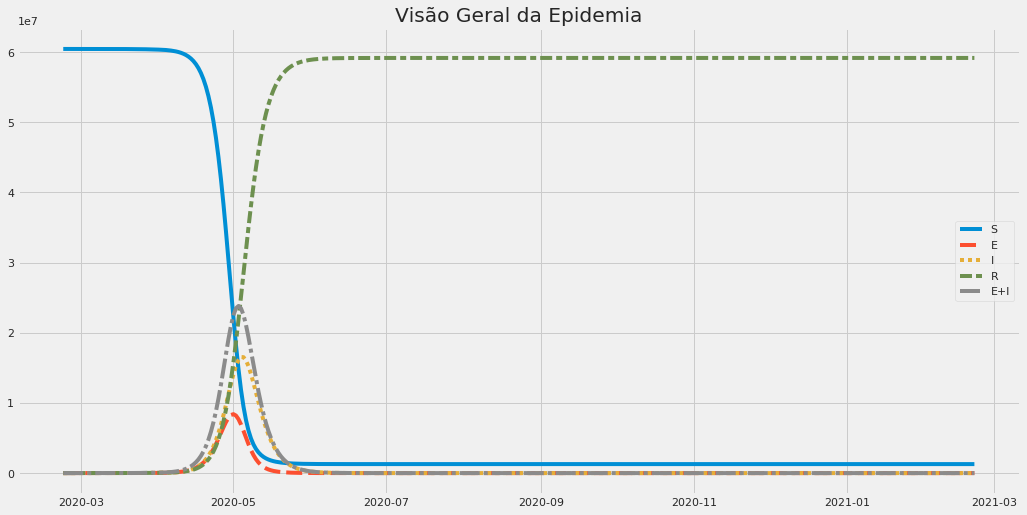

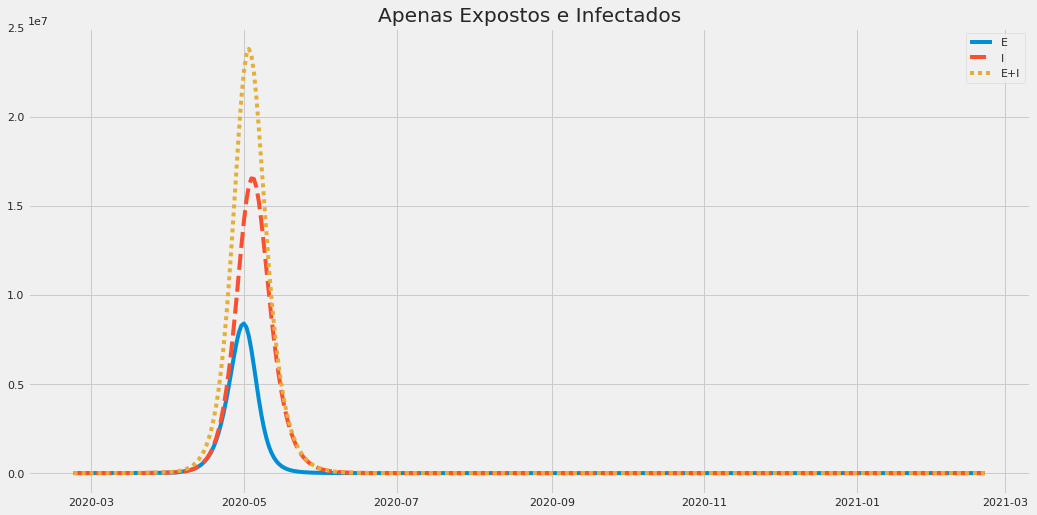

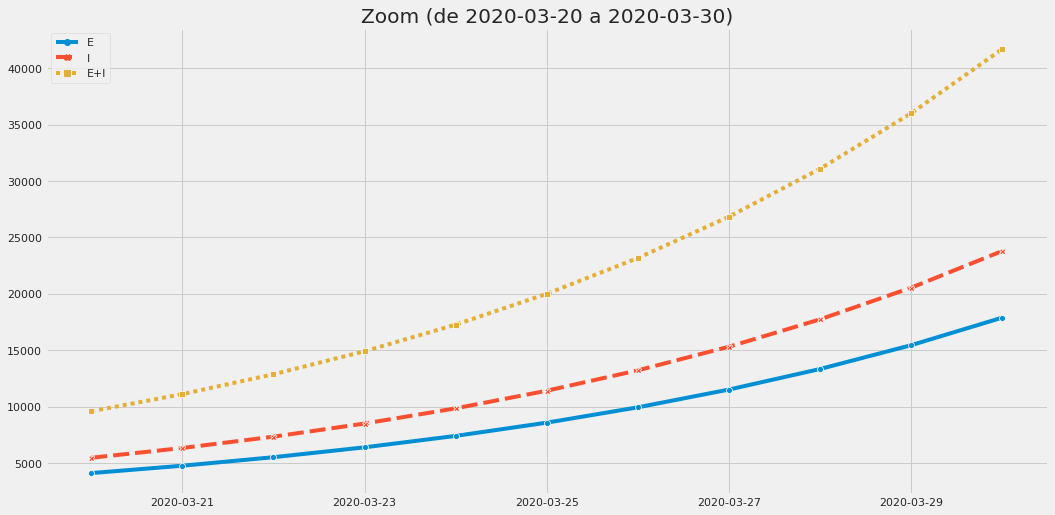

<Figure size 1152x576 with 0 Axes>

In [43]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_on='2020-03-20', zoom_length=10, file_name='with-mitigation')

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

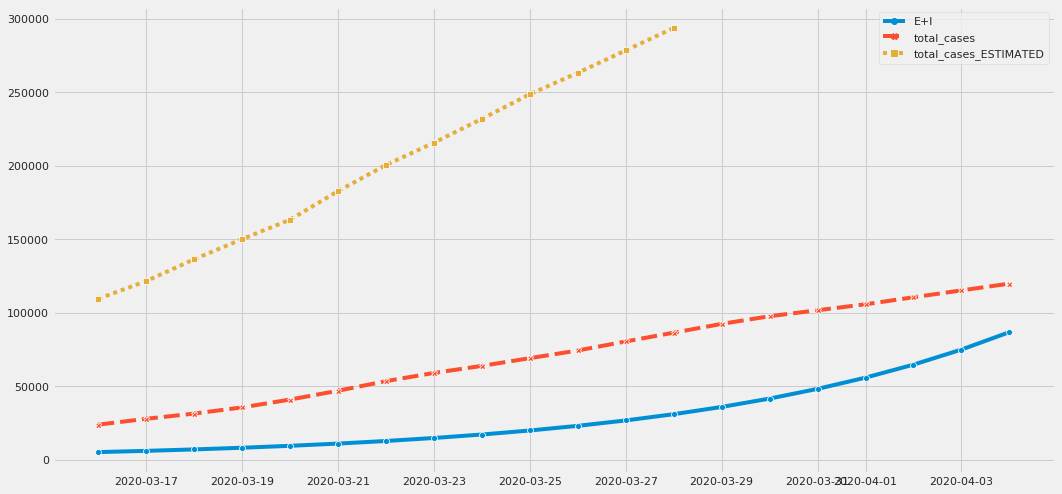

In [44]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_mitigated_vs_real = pd.concat([df_simulation_mitigation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_mitigated_vs_real[['E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Finalmente, comparemos os casos com e sem mitigação.

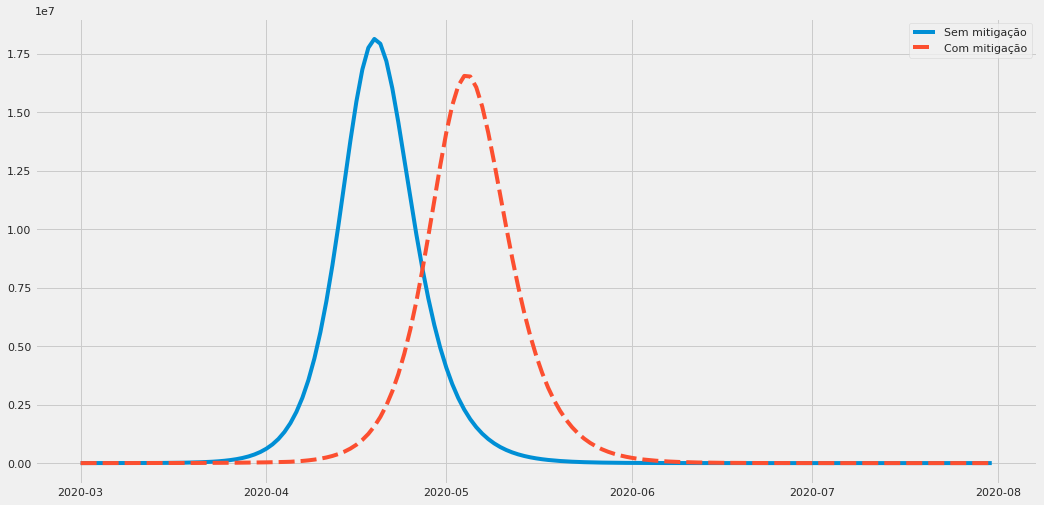

In [45]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['I'].rename('Com mitigação')], axis=1)['2020-03':'2020-07'])

ax.figure.savefig(results_folder + 'seir_mitigation_vs_no-mitigation' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [46]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_with_mitigation_model_output.{target_location.lower()}.csv')